# Toy Experiments

In [1]:
import os, sys
sys.path.append("..")

from src import distributions
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from basic import ScoreNetwork

import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output

from src.plotters import plot_results

from src.plotters import plot_trajectories

import os
SEED = 0xBADBEEF
torch.manual_seed(SEED); np.random.seed(SEED)

In [3]:
X_sampler = distributions.StandardNormalSampler(dim=2, device="cuda")
Y_sampler = distributions.SwissRollSampler(device="cuda")

DIM = 2
H = 100

batch_size = 1000
lr = 1e-4
n_steps = 100
GAMMA = 0.0
G_ITERS = 10
D_ITERS = 1
f_ITERS = 3
MAX_STEPS = 5000


ZC = 1
Z_STD = 1.0

In [4]:
def trainNOT(X_sampler, Y_sampler, G, G_opt, D, D_opt, sde, plot_n_samples=500):

    G_mse = []
    G_var = []
    
    for step in tqdm(range(MAX_STEPS)):

        for G_iter in range(G_ITERS):

            x0 = X_sampler.sample(batch_size)
            Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
            xN = G(torch.cat([x0, Z], axis = -1))

            G_loss = F.mse_loss(x0, xN) - D(xN).mean()
            
            G_opt.zero_grad(); G_loss.backward(); G_opt.step()
        
        # plotter 1
        if step % 100 == 0:
            clear_output(wait=True)
            
            original_dataset = torch.cat(
                [X_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
                dim=0,
            )[:plot_n_samples].cpu()
            target_dataset = torch.cat(
                [Y_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
                dim=0,
            )[:plot_n_samples].cpu()
            
            X = X_sampler.sample(plot_n_samples)
            
            Z = torch.randn(plot_n_samples, ZC, device='cuda') * Z_STD
            G_dataset = G(torch.cat([X, Z], axis = -1)).detach().cpu()
            f_dataset = sde(X).detach().cpu()

            G_mse.append(F.mse_loss(X.detach().cpu(), G_dataset).item())
            print('G mse:', G_mse[-1])


            with torch.no_grad():
                X = X_sampler.sample(10000)

                T_XZ_np = []
                
                # Our method results G
                for i in range(100):
                    Z = torch.randn(10000, ZC, device='cuda') * Z_STD
                    T_XZ_np.append(G(torch.cat([X, Z], axis = -1)).cpu().numpy())
            
                T_XZ_np = np.array(T_XZ_np)
                G_var.append(T_XZ_np.var(axis=0).mean(axis=0).mean().item())
                print('G var:', G_var[-1])
            
            
            plot_results(f_dataset, G_dataset, target_dataset)
            plt.show()
            
        for D_iter in range(D_ITERS):    
            x0 = X_sampler.sample(batch_size)
            x1 = Y_sampler.sample(batch_size)
            Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
            xN = G(torch.cat([x0, Z], axis = -1))
            D_loss = (- D(x1) + D(xN)).mean()
            D_opt.zero_grad(); D_loss.backward(); D_opt.step()

    return (G_mse, G_var)

In [5]:
def trainBM(X_sampler, Y_sampler, G, sde, sde_opt, plot_n_samples=500):

    G_mse = []
    G_var = []
    sde_mse = []
    sde_var = []
    
    for step in tqdm(range(MAX_STEPS)):

        for G_iter in range(G_ITERS):

            for f_iter in range(f_ITERS):
                x0 = X_sampler.sample(batch_size)
                Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
                xN = G(torch.cat([x0, Z], axis = -1))
                
                t = (torch.rand(x0.shape[0])[:, None]*0.995).cuda()
                xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)
                
                f_loss = ((sde.shift_model(xt, t) - (xN - xt)/(1-t)) ** 2).mean()
                sde_opt.zero_grad(); f_loss.backward(); sde_opt.step()
        
        # plotter 1
        if step % 100 == 0:
            clear_output(wait=True)
            
            original_dataset = torch.cat(
                [X_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
                dim=0,
            )[:plot_n_samples].cpu()
            target_dataset = torch.cat(
                [Y_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
                dim=0,
            )[:plot_n_samples].cpu()
            
            X = X_sampler.sample(plot_n_samples)
            
            Z = torch.randn(plot_n_samples, ZC, device='cuda') * Z_STD
            G_dataset = G(torch.cat([X, Z], axis = -1)).detach().cpu()
            f_dataset = sde(X).detach().cpu()

            G_mse.append(F.mse_loss(X.detach().cpu(), G_dataset).item())
            sde_mse.append(F.mse_loss(X.detach().cpu(), f_dataset).item())
            print('G mse:', G_mse[-1])
            print('sde mse:', sde_mse[-1])


            with torch.no_grad():
                X = X_sampler.sample(10000)

                T_XZ_np = []
                
                # Our method results G
                for i in range(100):
                    Z = torch.randn(10000, ZC, device='cuda') * Z_STD
                    T_XZ_np.append(G(torch.cat([X, Z], axis = -1)).cpu().numpy())
            
                T_XZ_np = np.array(T_XZ_np)
                G_var.append(T_XZ_np.var(axis=0).mean(axis=0).mean().item())
                print('G var:', G_var[-1])

                T_X_np = []
                for i in range(100):
                    T_X_np.append(sde(X).cpu().numpy())
            
                T_X_np = np.array(T_X_np)
                sde_var.append(T_X_np.var(axis=0).mean(axis=0).mean().item())
                print('sde var:', sde_var[-1])
            
            
            plot_results(f_dataset, G_dataset, target_dataset)
            plt.show()

    return (G_mse, G_var, sde_mse, sde_var)

In [6]:
def trainENOT(X_sampler, Y_sampler, G, G_opt, D, D_opt, sde, sde_opt, plot_n_samples=500):

    G_mse = []
    G_var = []
    sde_mse = []
    sde_var = []
    
    for step in tqdm(range(MAX_STEPS)):
            
        for G_iter in range(G_ITERS):

            for f_iter in range(f_ITERS):
                x0 = X_sampler.sample(batch_size)
                Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
                xN = G(torch.cat([x0, Z], axis = -1))
                
                t = (torch.rand(x0.shape[0])[:, None]*0.99).cuda()
                xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)
                
                f_loss = ((sde.shift_model(xt, t) - (xN - xt)/(1-t)) ** 2).mean()
                sde_opt.zero_grad(); f_loss.backward(); sde_opt.step()

            x0 = X_sampler.sample(batch_size)
            Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
            xN = G(torch.cat([x0, Z], axis = -1))

            t = (torch.rand(x0.shape[0])[:, None]*0.99).cuda()
            xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)
            
            f_x_t = sde.shift_model(xt, t)
            E = (xN - xt)/(1-t)

            loss1 = ((f_x_t*E).mean() - (f_x_t*f_x_t).mean()/2)*2
            loss2 = - D(xN).mean()

            G_loss = loss1 + loss2
            
            G_opt.zero_grad(); G_loss.backward(); G_opt.step()

        print(loss1.item(), loss2.item())
        
        
        # plotter 1
        if step % 100 == 0:
            clear_output(wait=True)
            
            # fig, axes = plot_trajectories(X_sampler, G, ZC, Z_STD, sde, k=10)
            # plt.show()
            
            original_dataset = torch.cat(
                [X_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
                dim=0,
            )[:plot_n_samples].cpu()
            target_dataset = torch.cat(
                [Y_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
                dim=0,
            )[:plot_n_samples].cpu()
            
            X = X_sampler.sample(plot_n_samples)
            
            Z = torch.randn(plot_n_samples, ZC, device='cuda') * Z_STD
            G_dataset = G(torch.cat([X, Z], axis = -1)).detach().cpu()
            f_dataset = sde(X).detach().cpu()

            G_mse.append(F.mse_loss(X.detach().cpu(), G_dataset).item())
            sde_mse.append(F.mse_loss(X.detach().cpu(), f_dataset).item())
            print('G mse:', G_mse[-1])
            print('sde mse:', sde_mse[-1])
            
            with torch.no_grad():
                X = X_sampler.sample(1000)

                T_XZ_np = []
                
                # Our method results G
                for i in range(100):
                    Z = torch.randn(1000, ZC, device='cuda') * Z_STD
                    T_XZ_np.append(G(torch.cat([X, Z], axis = -1)).cpu().numpy())
            
                T_XZ_np = np.array(T_XZ_np)
                G_var.append(T_XZ_np.var(axis=0).mean(axis=0).mean().item())
                print('G var:', G_var[-1])

                T_X_np = []
                for i in range(100):
                    T_X_np.append(sde(X).cpu().numpy())
            
                T_X_np = np.array(T_X_np)
                sde_var.append(T_X_np.var(axis=0).mean(axis=0).mean().item())
                print('sde var:', sde_var[-1])
            
            
            plot_results(f_dataset, G_dataset, target_dataset)
            plt.show()
            
        for D_iter in range(D_ITERS):    
            x0 = X_sampler.sample(batch_size)
            x1 = Y_sampler.sample(batch_size)
            Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
            xN = G(torch.cat([x0, Z], axis = -1))
            D_loss = (- D(x1) + D(xN)).mean()
            D_opt.zero_grad(); D_loss.backward(); D_opt.step()

    return (G_mse, G_var, sde_mse, sde_var)

## 4. Training

In [7]:
f = ScoreNetwork().cuda()

G = nn.Sequential(
    nn.Linear(DIM+ZC, H),
    nn.ReLU(True), 
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, DIM),
).cuda()


D = nn.Sequential(
    nn.Linear(DIM, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, 1),
).cuda()

G_opt = Adam(G.parameters(), lr=lr)
D_opt = Adam(D.parameters(), lr=lr)


class SDE(nn.Module):
    def __init__(self, shift_model, n_steps):
        super().__init__()
        self.shift_model = shift_model
        self.n_steps = n_steps
        self.delta_t = 1/n_steps
    
    def forward(self, x0, traj = False):
        x, t = x0, 0.0
        trajectory = [x]
        for step in range(self.n_steps):
            batch_size = x.shape[0]
            if step < n_steps - 1:
                x = x + self.delta_t*self.shift_model(x, torch.tensor(t).repeat(batch_size)[:, None].cuda()) + torch.randn_like(x)*np.sqrt(GAMMA*self.delta_t)
            else:
                x = x + self.delta_t*self.shift_model(x, torch.tensor(t).repeat(batch_size)[:, None].cuda())
            t += self.delta_t
            trajectory.append(x)
        if traj:
            return x, trajectory
        return x
    
    
sde = SDE(shift_model=f, n_steps=n_steps).cuda()
sde_opt = Adam(sde.parameters(), lr=lr)

G mse: 0.16753125190734863
G var: 0.000505391857586801


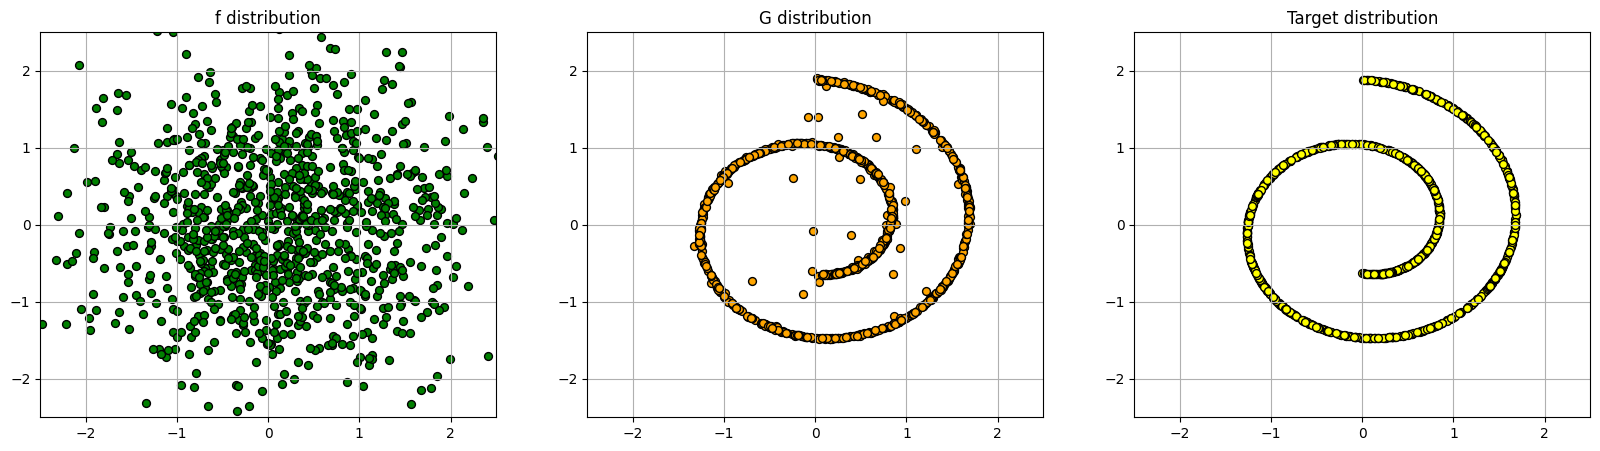

100%|██████████| 5000/5000 [01:02<00:00, 79.40it/s]


In [8]:
stats = trainNOT(X_sampler, Y_sampler, G, G_opt, D, D_opt, sde, plot_n_samples=1000)

In [ ]:
GAMMA = 0.0
G_ITERS = 10
D_ITERS = 1
f_ITERS = 3
MAX_STEPS = 1000

G mse: 0.15898846089839935
sde mse: 0.15296179056167603
G var: 0.00031241722172126174
sde var: 4.4181325264958105e-13


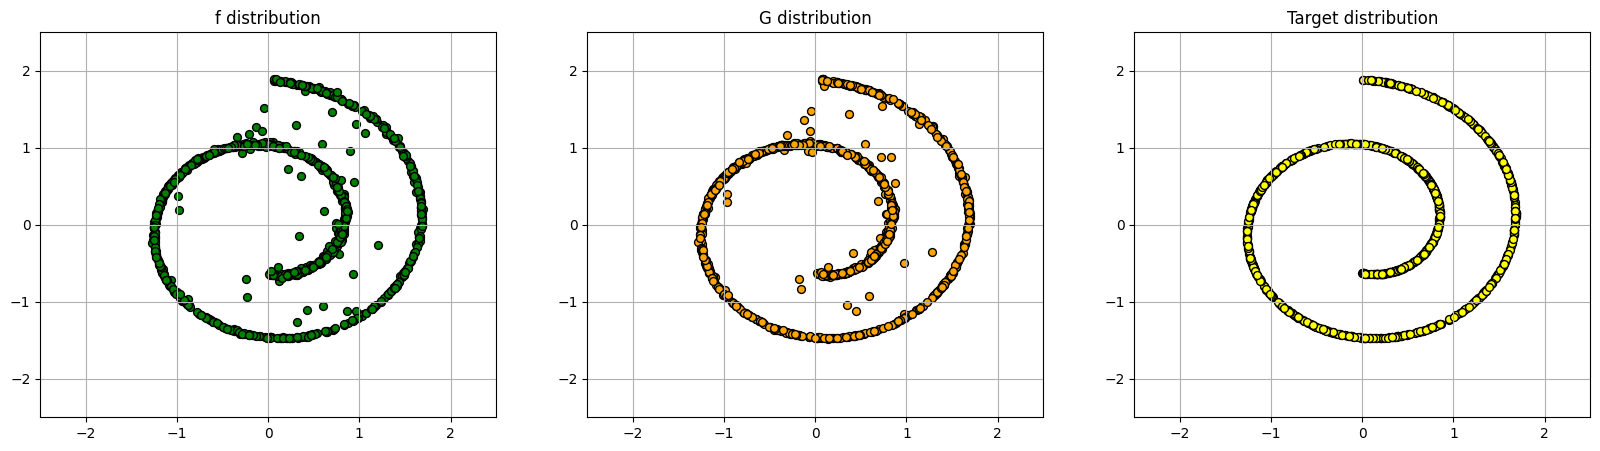

100%|██████████| 5000/5000 [07:14<00:00, 11.51it/s]


In [9]:
stats = trainBM(X_sampler, Y_sampler, G, sde, sde_opt, plot_n_samples=1000)

In [ ]:
# torch.save(G, 'G.pt')
# torch.save(D, 'D.pt')
# torch.save(sde, 'sde.pt')

# G = torch.load('G.pt')
# D = torch.load('D.pt')
# sde = torch.load('sde.pt')


# G_opt = Adam(G.parameters(), lr=lr)
# D_opt = Adam(D.parameters(), lr=lr)
# sde_opt = Adam(sde.parameters(), lr=lr)

In [10]:
GAMMA = 0.5
G_ITERS = 10
D_ITERS = 1
f_ITERS = 3
MAX_STEPS = 1000

G mse: 0.16883084177970886
sde mse: 0.48728594183921814
G var: 0.0007434359285980463
sde var: 0.3102109134197235


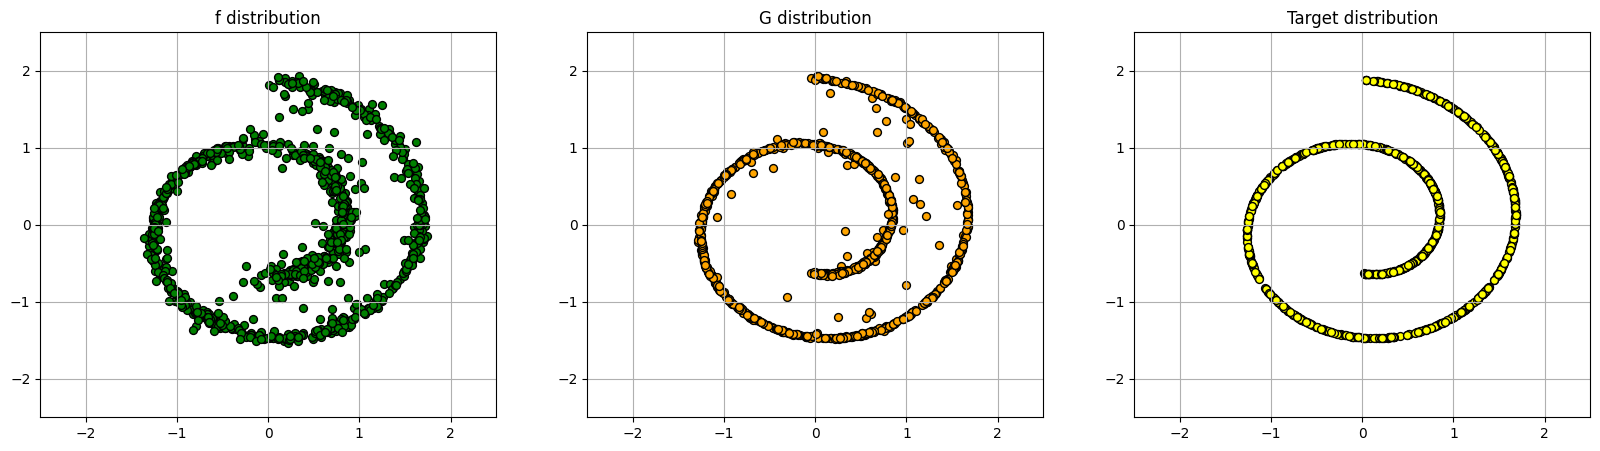

 90%|█████████ | 905/1000 [01:20<00:24,  3.93it/s]

0.609702467918396 -2.7720229625701904
0.8820995688438416 -2.797609567642212
0.7988225817680359 -2.766649007797241
0.9764686822891235 -2.7794647216796875


 91%|█████████ | 909/1000 [01:20<00:14,  6.48it/s]

1.0941176414489746 -2.762648105621338
0.9943556189537048 -2.8196723461151123
0.9261283278465271 -2.82142972946167
0.985883891582489 -2.8246798515319824


 91%|█████████▏| 913/1000 [01:20<00:09,  9.46it/s]

1.1434332132339478 -2.869683265686035
0.8104420900344849 -2.8804636001586914
1.0364012718200684 -2.8739218711853027
0.8273153901100159 -2.856226682662964


 92%|█████████▏| 917/1000 [01:20<00:06, 12.20it/s]

0.6411776542663574 -2.878021240234375
0.7366852760314941 -2.901948928833008
0.6880979537963867 -2.901951789855957
0.9912614226341248 -2.9274957180023193


 92%|█████████▏| 921/1000 [01:21<00:05, 14.22it/s]

0.9235153198242188 -2.9522743225097656
0.6567915081977844 -2.9312572479248047
0.9259687066078186 -2.9494166374206543
0.8112119436264038 -2.968632698059082


 92%|█████████▎| 925/1000 [01:21<00:04, 15.54it/s]

0.7408590316772461 -3.0020992755889893
0.7338687181472778 -2.988529920578003
1.0256500244140625 -3.001382350921631
0.719679057598114 -3.0077157020568848


 93%|█████████▎| 929/1000 [01:21<00:04, 15.86it/s]

0.8512049317359924 -2.9415714740753174
0.8701209425926208 -3.0662946701049805
0.9506869316101074 -2.998718500137329
0.8792445659637451 -3.0321450233459473


 93%|█████████▎| 933/1000 [01:21<00:04, 16.31it/s]

1.087430715560913 -3.0263874530792236
0.8015079498291016 -3.086601734161377
0.8431062698364258 -3.137983798980713
1.0030843019485474 -3.044992446899414


 94%|█████████▎| 937/1000 [01:21<00:03, 16.66it/s]

0.7026460766792297 -3.105954170227051
0.9249840378761292 -3.0610485076904297
0.7741130590438843 -3.050145149230957
0.7316756248474121 -3.0654001235961914


 94%|█████████▍| 941/1000 [01:22<00:03, 16.74it/s]

1.0563502311706543 -3.039684295654297
0.7761262059211731 -2.988551139831543
0.8535833954811096 -3.0470595359802246
0.7792325019836426 -2.8989779949188232


 94%|█████████▍| 945/1000 [01:22<00:03, 17.00it/s]

0.727985143661499 -2.9759366512298584
1.024770975112915 -2.902353525161743
0.8378133177757263 -2.887216091156006
1.0245447158813477 -2.7571754455566406


 95%|█████████▍| 949/1000 [01:22<00:02, 17.24it/s]

0.6967570185661316 -2.8264591693878174
1.153382658958435 -2.7889552116394043
1.0382933616638184 -2.7499523162841797
0.7685574889183044 -2.7365145683288574


 95%|█████████▌| 953/1000 [01:22<00:02, 17.15it/s]

0.6744155883789062 -2.6577813625335693
0.7896349430084229 -2.6944220066070557
0.804993212223053 -2.662412405014038
0.8630589842796326 -2.630042552947998


 96%|█████████▌| 957/1000 [01:23<00:02, 16.36it/s]

1.0276734828948975 -2.611264944076538
0.7659385204315186 -2.639615297317505
0.8082333207130432 -2.6377813816070557
0.7306947112083435 -2.6372246742248535


 96%|█████████▌| 961/1000 [01:23<00:02, 16.68it/s]

0.8240720629692078 -2.643106460571289
0.7599281072616577 -2.6541354656219482
0.7556381821632385 -2.6401267051696777
1.0318996906280518 -2.6570353507995605


 96%|█████████▋| 965/1000 [01:23<00:02, 16.87it/s]

0.6499416828155518 -2.6540615558624268
0.6614415049552917 -2.644265651702881
0.7876411080360413 -2.655529022216797
0.8357459902763367 -2.6458487510681152


 97%|█████████▋| 969/1000 [01:23<00:01, 16.96it/s]

0.8787487149238586 -2.6310558319091797
0.7978383302688599 -2.691528797149658
1.0038936138153076 -2.66727352142334
0.7587828040122986 -2.704854965209961


 97%|█████████▋| 973/1000 [01:24<00:01, 16.74it/s]

0.7893493175506592 -2.6780850887298584
0.9172593355178833 -2.717116117477417
0.8230500817298889 -2.7034566402435303
0.8873122930526733 -2.709951639175415


 98%|█████████▊| 977/1000 [01:24<00:01, 16.77it/s]

0.8039335012435913 -2.7429635524749756
0.7450013160705566 -2.6978676319122314
0.7694411277770996 -2.731282949447632
0.8060235977172852 -2.7721009254455566


 98%|█████████▊| 981/1000 [01:24<00:01, 16.84it/s]

0.7599481344223022 -2.8282041549682617
0.7228080630302429 -2.758709192276001
1.0898637771606445 -2.820436716079712
0.7523539662361145 -2.8316924571990967


 98%|█████████▊| 985/1000 [01:24<00:00, 17.10it/s]

1.0002083778381348 -2.7871017456054688
0.8919514417648315 -2.828123092651367
0.5763256549835205 -2.8615896701812744
0.8142604231834412 -2.8491170406341553


 99%|█████████▉| 989/1000 [01:25<00:00, 16.45it/s]

1.0103225708007812 -2.8566558361053467
0.9300743937492371 -2.899778366088867
0.8795272707939148 -2.882416248321533
0.5719565153121948 -2.936128854751587


 99%|█████████▉| 993/1000 [01:25<00:00, 16.60it/s]

0.7797265648841858 -2.908449411392212
0.9434685707092285 -2.911679744720459
1.3388372659683228 -2.980518102645874
0.8512517809867859 -2.945643901824951


100%|█████████▉| 997/1000 [01:25<00:00, 16.71it/s]

0.8826653361320496 -3.0155272483825684
0.7964808940887451 -2.9753077030181885
0.8037511110305786 -2.996110200881958
0.9522671699523926 -2.977670669555664


100%|██████████| 1000/1000 [01:25<00:00, 11.66it/s]

0.698843240737915 -3.0405280590057373
1.0605145692825317 -2.995732069015503
0.7534219026565552 -2.9830470085144043


In [11]:
stats = trainENOT(X_sampler, Y_sampler, G, G_opt, D, D_opt, sde, sde_opt, plot_n_samples=1000)

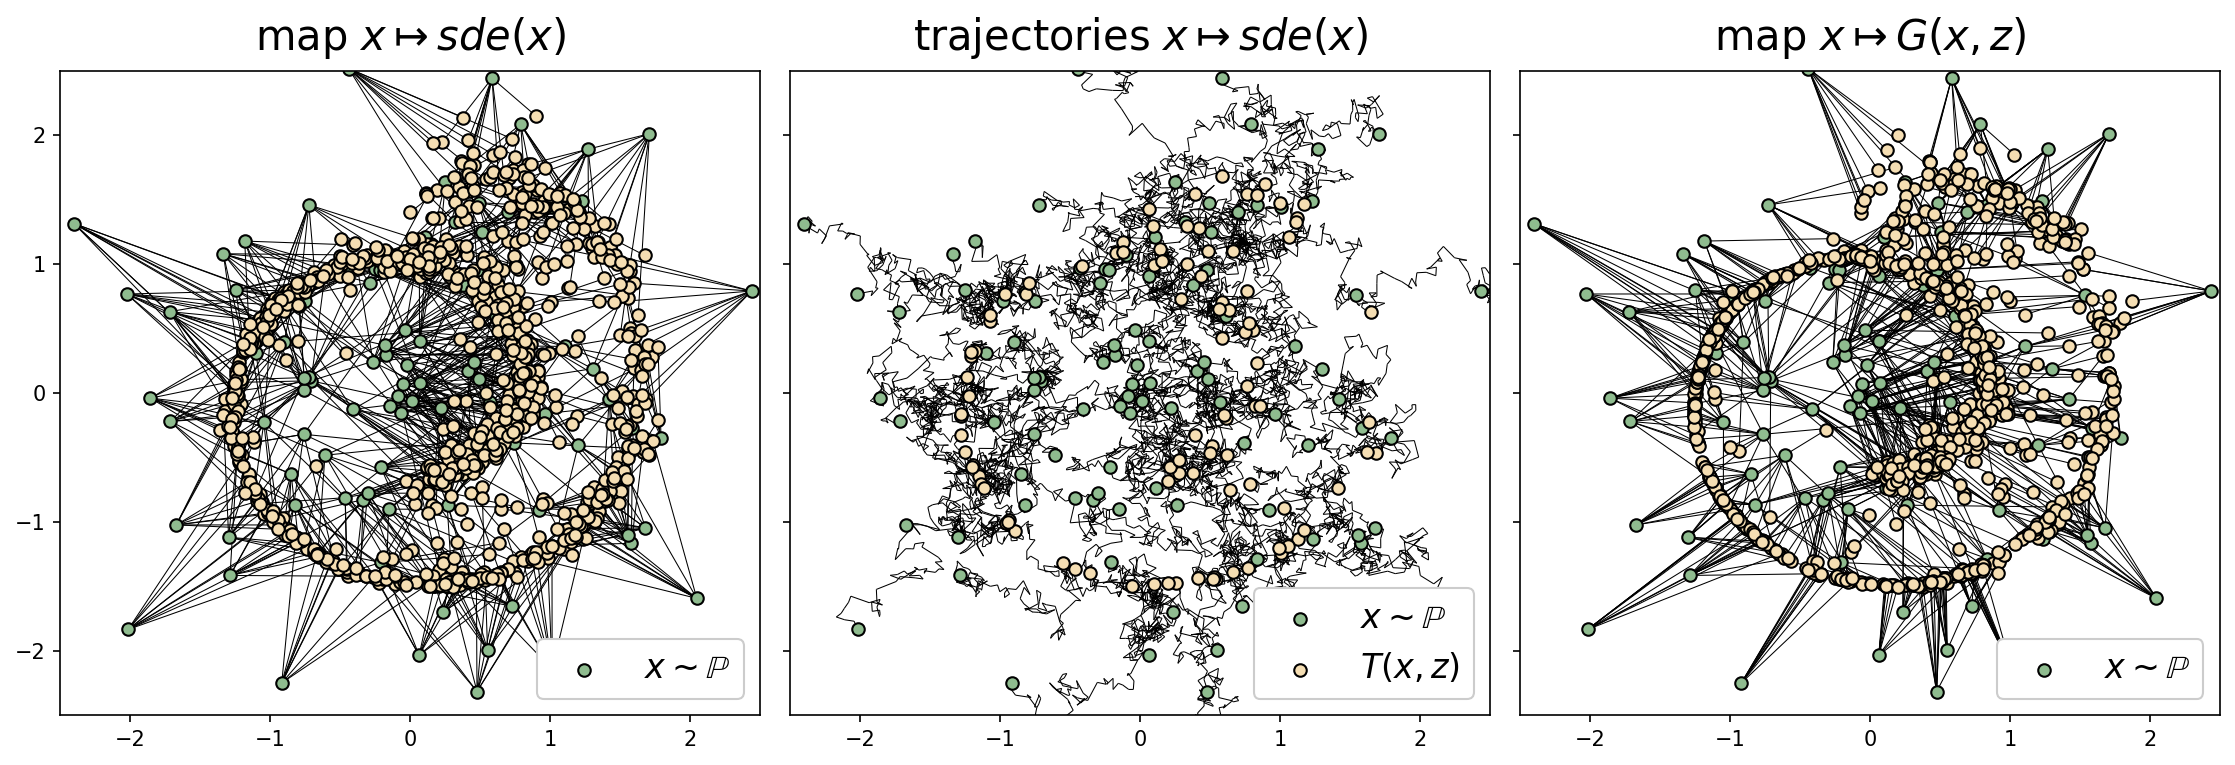

In [15]:
fig, axes = plot_trajectories(X_sampler, G, ZC, Z_STD, sde, k=10)
plt.show()